# Translation

In this project we will be teaching a neural network to translate from a language to English or viceversa.  
  
This is made possible by the simple but powerful idea of the **sequence to sequence network**, in which two recurrent neural networks work together to transform one sequence to another. An **encoder network** condenses an input sequence into a vector and a **decoder network** unfolds that vector into a new sequence.  
  
A good probabilistic translation model requires a large dataset (to cover as many cases as possible) and extensive training, so I will just show how it works with limited examples and the translation accuracy is not in focus (no real validation / test).  
  
## The dataset

The dataset used in the example involves short sentence pairs used in the flash card software Anki.  
  
The dataset is called “Tab-delimited Bilingual Sentence Pairs” and is part of the [Tatoeba Project](https://tatoeba.org/) and listed on the [ManyThings.org site](https://www.manythings.org/anki/) for helping English as a Second Language students.


The files have an attribution column so we need to strip it away before reading the input files.  
This has to be done only once.  
  
### Prepare input files (one-off)

In [ ]:
"""
Script to strip attribution information from tab-separated translation files.

Input format: English_text \t Other_language_text \t CC-BY_attribution
Output format: English_text \t Other_language_text
"""

import sys
import os

def strip_attribution(input_file, output_file=None):
    """
    Strip attribution column from tab-separated translation file.
    
    Args:
        input_file (str): Path to input file
        output_file (str): Path to output file (optional, defaults to input_clean.txt)
    """
    
    # Set default output filename if not provided
    if output_file is None:
        base_name = os.path.splitext(input_file)[0]
        output_file = f"{base_name}_clean.txt"  # create a file with suffix clean
    
    try:
        with open(input_file, 'r', encoding='utf-8') as infile:
            with open(output_file, 'w', encoding='utf-8') as outfile:
                line_count = 0
                processed_count = 0
                
                for line in infile:
                    line_count += 1
                    line = line.rstrip('\n\r')
                    
                    # Skip empty lines
                    if not line.strip():
                        continue
                    
                    # Split by tab
                    parts = line.split('\t')
                    
                    # Check if we have at least 3 parts (English, Other, Attribution)
                    if len(parts) >= 3:
                        english_text = parts[0]
                        other_text = parts[1]
                        
                        # Write only the first two columns
                        outfile.write(f"{english_text}\t{other_text}\n")
                        processed_count += 1
                    else:
                        print(f"Warning: Line {line_count} doesn't have expected format: {line}")
                
                print(f"Processing complete!")
                print(f"Total lines read: {line_count}")
                print(f"Lines processed: {processed_count}")
                print(f"Output written to: {output_file}")
                
    except FileNotFoundError:
        print(f"Error: Input file '{input_file}' not found.")
        return False
    except Exception as e:
        print(f"Error processing file: {e}")
        return False
    
    return True



I did it for a couple of languages:

In [ ]:
strip_attribution("../datasets/translations/ita.txt")


In [ ]:
strip_attribution("../datasets/translations/jpn.txt")


In [ ]:
strip_attribution("../datasets/translations/cmn.txt")


In [1]:
# Have a look at the available datasets

! ls -lh "../datasets/translations/"

total 381352
-rw-r--r--@ 1 Massimo  staff   4.2M Jun  4 01:29 cmn.txt
-rw-r--r--  1 Massimo  staff   1.8M Jun  7 17:16 cmn_clean.txt
-rw-r--r--@ 1 Massimo  staff    48M Jun  4 01:29 deu.txt
-rw-r--r--  1 Massimo  staff    22M Jun  6 16:31 deu_clean.txt
-rw-r--r--@ 1 Massimo  staff   9.1M Mar 12  2017 fra_clean.txt
-rw-r--r--@ 1 Massimo  staff    53M Jun  4 01:29 ita.txt
-rw-r--r--  1 Massimo  staff    22M Jun  7 17:15 ita_clean.txt
-rw-r--r--@ 1 Massimo  staff    18M Jun  4 01:29 jpn.txt
-rw-r--r--@ 1 Massimo  staff   8.7M Jun  7 17:15 jpn_clean.txt


Note that I have prepared non-latin languages dataset too, specifically Japanese (jpn) and Chinese (cmn),  
They will require some additional pre-processing that I want to show.  

## Prepare data structures

We will now prepare the data structures to store the input data and a couple of helper functions.
### Unicode to ASCII
The files are all in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.


In [2]:
import unicodedata
import re

In [3]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def _unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


We can see how this works for a japanese sentence:

In [4]:
japString = "なさい。"
print(japString)

なさい。


In [5]:
print(_unicodeToAscii(japString))

なさい。


### Normalise strings
Lowercase, trim and remove non-letter characters helper.


In [6]:
def _normaliseString(s):
    s = _unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?。])", "", s)
    return s.strip()

In [7]:
print(_normaliseString(japString))

なさい


In [8]:
print(_normaliseString(" this is a STRANGE sentence "))

this is a strange sentence


### Split a sentence into words
Now this is easy for latin languages by splitting words when a  blank character is encountered but this is not working for languages such as Japanese or Chinese as they don't separate words using spaces (and it's not always true that one character = one word, often words are formed by two or more characters).  
  
  Let's see some example:

In [9]:
'English sentences are easy to split'.split(' ')

['English', 'sentences', 'are', 'easy', 'to', 'split']

In [10]:
testSentenceJap = 'お行儀よくしなさい'  # O gyōgi yoku shi nasai: 5 words
testSentenceJap.split(' ')

['お行儀よくしなさい']

As you can see, the sentence is handled as one single word. This will make the model useless.  
There are several ways to split sentences in Chinese / Japanese using external specific libraries, these are simple examples:

In [11]:
%pip install nagisa


Note: you may need to restart the kernel to use updated packages.


In [12]:
import nagisa   # Japanese splitting


In [13]:
nagisa.tagging(testSentenceJap).words

['お', '行儀', 'よく', 'し', 'なさい']

Perfect. We use another library for Chinese:

In [14]:
testSentenceCmn = "我爱人工智能"  #Wǒ ài réngōng zhìnéng: 3 or 4 words (the last two can be combined together)

In [16]:
%pip install jieba


Note: you may need to restart the kernel to use updated packages.


In [17]:
import jieba  # Chinese words splitting library


In [18]:
wordsGenerator = jieba.cut(testSentenceCmn)


In [19]:
list(wordsGenerator)

Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/8g/4xvwd0w96wg80spn6kr2rh640000gp/T/jieba.cache
Loading model from cache /var/folders/8g/4xvwd0w96wg80spn6kr2rh640000gp/T/jieba.cache
Loading model cost 0.377 seconds.
Loading model cost 0.377 seconds.
Prefix dict has been built successfully.
Prefix dict has been built successfully.


['我', '爱', '人工智能']

It's working. Let's put all together in a function:

In [20]:
def _splitSentence(langName,sentence):
    """
    langName:  the input language, suing the smae convention as the dataset
    sentence:  the string to split
    return:    list of words (strings)
    """

    if langName == "jpn":
        return nagisa.tagging(sentence).words  # Japanese
    elif langName == "cmn":
        return list(jieba.cut(sentence))  # Chinese
    else:
        return sentence.split(' ')  # All other languages; add more tests if you want to split other non-latin 

In [21]:
_splitSentence("jpn",testSentenceJap)

['お', '行儀', 'よく', 'し', 'なさい']

In [22]:
_splitSentence("cmn", testSentenceCmn)

['我', '爱', '人工智能']

### Filter only short sentences
Since there are a lot of example sentences and we want to train something quickly, we’ll trim the data set to only relatively short and simple sentences. Here the maximum number of words (use the previously defined function to split) is used as threshold.


In [23]:
MAX_LENGTH = 10  # keep only sentences up to 10 words

def _filterSentence(langName, s):
    # s: input string
    # langName: language of the sentence
    # returns True if s is shorter than threshold MAX_LENGTH
    w = _splitSentence(langName, s)
    return len(w) < MAX_LENGTH

def _filterPair(langName, p):
    # langName: language of the sentence
    # p: input pair of strings
    # returns True if s is shorter than threshold MAX_LENGTH
    return _filterSentence(langName, p[0]) and _filterSentence(langName, p[1])
 


def _filterPairs(langName, pairs):
    # langName: language of the sentence
    # pairs: all dataset pairs
    # return subset of shorter pairs
    return [pair for pair in pairs if _filterPair(langName, pair)]

In [24]:
_filterSentence("jpn", japString)

True

In [25]:
_filterSentence("eng", "this is a sentence too long, note that punctuation is included in the count!")

False

In [26]:
japPair = ['please.', japString]
_filterPair("jpn", japPair)

True

## Read the files and prepare the data

To read the data file we will split the file into lines and then split lines into pairs. The files are all English → Other Language, so if we want to translate from Other Language → English we can use the reverse flag to reverse the pairs.  
Read lines and words are stored in two variables of **class Lang**: one for English and one for input language. 
The class Lang (language) contains the language name (a string), the found list of words and methods to index a word into a number and viceversa (used for training the network).  
It also contains the function to split a sentence into words so we can leverage the language name, which is known.
  
  The full process for preparing the data is:

- Read text file and split into lines, split lines into pairs

- Normalize text, filter by length and content

- Make word lists from sentences in pairs

In [27]:
SOS_token = 0  # Note the use of start and end sentence marks.  
EOS_token = 1

# The Language class, contains the words

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def _splitSentence(self,sentence):
        if self.name == "jpn":
            return nagisa.tagging(sentence).words
        elif self.name == "cmn":
            return list(jieba.cut(sentence))
        else:
            return sentence.split(' ')
        
    def addSentence(self, sentence):
        words = self._splitSentence(sentence) # first split the sentence into words

        for word in words:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


In [28]:
def prepareData(lang, reverse=False):

    # read the data from the given file and instantiate the proper Language class
    # lang: string representing the language; used to access the file
    # reverse: boolean; true if translation is from language to English; false if viceversa
    # return: 
    # - Input Lang class
    # - Output Lang class
    # - Pairs of sentences
    
    print("Reading lines...")

        # Read the file and split into lines
    lines = open('../datasets/translations/%s_clean.txt' % (lang), encoding='utf-8').\
        read().strip().split('\n')

        # Split every line into pairs and normalize
    pairs = [[_normaliseString(s) for s in l.split('\t')] for l in lines]
    print("Read %s sentence pairs" % len(pairs))

        # Reverse pairs + make Lang instances + filter pairs (only short ones)
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        
        input_lang = Lang(lang)
        output_lang = Lang("eng")
        
        pairs = _filterPairs(input_lang.name, pairs)

    else:
        input_lang = Lang("eng")
        output_lang = Lang(lang)

        pairs = _filterPairs(output_lang.name, pairs)

            
    print("Trimmed to %s sentence pairs" % len(pairs))
    
        # extract words
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
        
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    
    return input_lang, output_lang, pairs

# First use case: English -> Italian

In [247]:
input_lang, output_lang, pairs = prepareData('ita', False)   # eng -> Italian


Reading lines...
Read 390190 sentence pairs
Trimmed to 369926 sentence pairs
Counting words...
Counted words:
eng 15772
ita 30582


The input and output languages contain several attributes (name, number of words, ...) and methods (convert a word into its index and viceversa):

In [248]:
input_lang.name

'eng'

In [249]:
output_lang.name

'ita'

In [250]:
output_lang.n_words

30582

A total of 30K words are stored for Italian. This number will be used to size the neural network.  
  
  Example of pair sentence (english, italian):

In [251]:
pairs[42]

['do it', 'lo faccia']

In [252]:
output_lang.word2index["ciao"]  # get the index of italian word "ciao"

2

In [253]:
output_lang.index2word[2]  #  verify the word associated to index 2 is 'ciao'

'ciao'

In [254]:
input_lang.word2index["hello"] # works also for english 

15

In [255]:
output_lang.word2count['ciao'] # number of occurences of word 'ciao'

16

In [256]:
pairs[999]

["i'm tidy", 'io sono ordinato']

In [257]:
pairs[999][1].split(' ')

['io', 'sono', 'ordinato']

## Preparing Training Data
To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.


In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from torch import optim

import numpy as np


In [48]:
import random


In [258]:
# For determinism

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [50]:
def get_device():
    """
    Get the best available device (CPU/GPU/MPS) with proper MPS handling.
    """
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        # Check if Apple MPS is properly supported
        try:
            # Test MPS with a simple operation
            test_tensor = torch.randn(2, 2, device="mps")
            _ = test_tensor + test_tensor
            return torch.device("mps")
        except Exception as e:
            print(f"MPS available but not working properly: {e}")
            print("Falling back to CPU")
            return torch.device("cpu")
    else:
        return torch.device("cpu")


In [51]:
# Set device
myDevice = get_device()
print(f"Using device: {myDevice}")

Using device: mps


In [52]:
myDevice = "cpu"

### Embed data into tensors 

To embed text into tokens (using tokenise) and finally to indexes and tensors we need a couple of helper functions.  

In [130]:
def indexesFromSentence(lang, sentence):
    words = lang._splitSentence(sentence)
    return [lang.word2index[word] for word in words]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    
    try:
        
        # Create tensor on CPU first, then move to device
        tensor = torch.tensor(indexes, dtype=torch.long)
        tensor = tensor.to(myDevice, non_blocking=True)
        
        return tensor.view(1, -1)
        
    except Exception as e:
        print(f"Error creating tensor on {myDevice}: {e}")
        print("Creating tensor on CPU instead...")
        
        # Fallback to CPU
        tensor = torch.tensor(indexes, dtype=torch.long, device='cpu')
        return tensor.view(1, -1)
    

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)



The first helper, *indexesFromSentence* gets a sentence, tokenise it and maps each token into its index, based on the language:

In [259]:
testSentenceEN = "i love machine learning and artificial intelligence"

indexesFromSentence(input_lang, testSentenceEN)  # input language is English

[16, 619, 8723, 2449, 1207, 3207, 11079]

Similarly, the helper *tensorFromSentence* gets a sentence, tokenises it and maps each token into its tensor (note it adds 1 at the end  = End Of Sentence, EOS token):

In [260]:
tensorFromSentence(input_lang, testSentenceEN)

tensor([[   16,   619,  8723,  2449,  1207,  3207, 11079,     1]])

## Load the data
Now we are ready to load the data for the model training.  
After setting the language pre-processing criteria, the next step is to create batches of training data using iterators.    
We use a batch of 32, can be customised below.  
As the sentences are many and the training will be too long (depending on GPU/CPU), I take a small percentage of the entire set:

In [56]:
BATCH_SIZE = 32  # use this to set the training batch size
TRAIN_PERCENT = 0.1  # use this to set the training size

def get_trainDataloader(input_lang, output_lang, pairs, device):

        # get the training split
    n = len(pairs)
    trainSplit = int(n * TRAIN_PERCENT)
    print(f"train sentences: {trainSplit}")
    
        # Pre-allocate arrays on CPU 
    input_ids = np.zeros((trainSplit, MAX_LENGTH), dtype=np.int64)  
    target_ids = np.zeros((trainSplit, MAX_LENGTH), dtype=np.int64) 

        # tokenise and get indexes
    for idx, (inp, tgt) in enumerate(pairs[:trainSplit]):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

        # Create tensors on CPU first, then move to device
    try:
            # Create tensors with proper dtype (int64/long is more compatible with MPS)
        input_tensor = torch.from_numpy(input_ids).long()
        target_tensor = torch.from_numpy(target_ids).long()
    
            # Move to device safely
        input_tensor = input_tensor.to(device, non_blocking=True)
        target_tensor = target_tensor.to(device, non_blocking=True)
    
        train_data = TensorDataset(input_tensor, target_tensor)
    
    except Exception as e:
        print(f"Error moving tensors to {device}: {e}")
        print("Falling back to CPU...")
        device = torch.device("cpu")
        input_tensor = torch.from_numpy(input_ids).long()
        target_tensor = torch.from_numpy(target_ids).long()
        
        train_data = TensorDataset(input_tensor, target_tensor)



    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)
    
    return train_dataloader

Get the train dataset for Italian language:

In [261]:
trainData = get_trainDataloader(input_lang, output_lang, pairs, myDevice)


train sentences: 36992


In [262]:
type(trainData)

torch.utils.data.dataloader.DataLoader

In [263]:
# Check a batch
for src_batch, tgt_batch in trainData:
    print("Source:", src_batch.shape)
    print("Target:", tgt_batch.shape)
    break

Source: torch.Size([32, 10])
Target: torch.Size([32, 10])


In [264]:
# pick a random index less than the batch size
index = random.randrange(len(src_batch))
index

7

In [265]:
print(src_batch[index])

tensor([13, 19, 66,  1,  0,  0,  0,  0,  0,  0])


In [266]:
for i in src_batch[index]:
    print (input_lang.index2word[i.item()])

go
see
tom
EOS
SOS
SOS
SOS
SOS
SOS
SOS


In [267]:
print(tgt_batch[index])

tensor([  48,  115, 1625,  179,    1,    0,    0,    0,    0,    0])


In [268]:
for i in tgt_batch[index]:
    print (output_lang.index2word[i.item()])

vada
a
trovare
tom
EOS
SOS
SOS
SOS
SOS
SOS


# Model

Recurrent Neural Network, or RNN, is a network that operates on a sequence and uses its own output as input for subsequent steps.

A **Sequence to Sequence** (seq2seq) network is a model consisting of two RNNs called the encoder and decoder. The encoder reads an input sequence and outputs a single vector and the decoder reads that vector to produce an output sequence.

Unlike sequence prediction with a single RNN, where every input corresponds to an output, the seq2seq model frees us from sequence length and order, which makes it ideal for translation between two languages.  
In the general case, input sequences and output sequences have different lengths and the entire input sequence is required in order to start predicting the target.  

Consider the sentence *Je ne suis pas le chat noir* → I am not the black cat. Most of the words in the input sentence have a direct translation in the output sentence but are in slightly different orders, e.g. *chat noir* and black cat. Because of the *ne/pas* construction there is also one more word in the input sentence. It would be difficult to produce a correct translation directly from the sequence of input words.  
  

## The Encoder

With a seq2seq model the encoder creates a single vector which, in the ideal case, encodes the “meaning” of the input sequence into a single vector — a single point in some N dimensional space of sentences.  
This **Context Vector** is said to contain the abstract representation of the input language sequence.

The encoder of a seq2seq network is a RNN that processes the input sequence and outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

In [68]:
HIDDEN_SIZE = 128

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden


In [269]:
encoder = EncoderRNN(input_lang.n_words, HIDDEN_SIZE)
encoder = encoder.to(myDevice)


In [270]:
print("Encoder's state_dict:")
for param_tensor in encoder.state_dict():
    print(param_tensor, "\t", encoder.state_dict()[param_tensor].size())


Encoder's state_dict:
embedding.weight 	 torch.Size([15772, 128])
gru.weight_ih_l0 	 torch.Size([384, 128])
gru.weight_hh_l0 	 torch.Size([384, 128])
gru.bias_ih_l0 	 torch.Size([384])
gru.bias_hh_l0 	 torch.Size([384])


In [271]:
encoder

EncoderRNN(
  (embedding): Embedding(15772, 128)
  (gru): GRU(128, 128, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

The encoder is pretty simple:
- the input layer (embedding) is taking all the input language (in this case English) words (around 15k) 
- the hidden layer is a GRU (Gated Recurrent Unit) - simpler than a LSTM - with a dropout mechanism (drops 10% of the weights) for regularisation

##  The Decoder
The decoder is another RNN that takes the encoder output vector and outputs a sequence of words to create the translation.

The decoder is trained to predict the next characters of the target sequence, given previous characters of the target sequence. Specifically, it is trained to turn the target sequences into the same sequences but offset by one timestep in the future, a training process called "teacher forcing" in this context. Importantly, the encoder uses as initial state the state vectors from the encoder, which is how the decoder obtains information about what it is supposed to generate.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string <SOS> token, and the first hidden state is the context vector (the encoder’s last hidden state).

In [72]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=myDevice).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

### Teacher forcing
While running the encoder on the input sequence is relatively straightforward, handling the input and output of the decoder requires more care. The most common approach is called teacher forcing.  
This method acts like a Regularization. So that the model trains efficiently and fastly during the process.  
  
“Teacher forcing” is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input. Using teacher forcing causes it to converge faster but when the trained network is exploited, it may exhibit instability.  
  
You can observe outputs of teacher-forced networks that read with coherent grammar but wander far from the correct translation - intuitively it has learned to represent the output grammar and can “pick up” the meaning once the teacher tells it the first few words, but it has not properly learned how to create the sentence from the translation in the first place.  
  
Because of the freedom PyTorch’s autograd gives us, we can randomly choose to use teacher forcing or not with a simple if statement.  
Another possibility would be to use a teach force ratio (tfr), where we can actually control the flow of input words to the decoder. Sending either of the word (actual target word or predicted target word) can be regulated with a probability of say 50%, so at any time step, one of them is passed during the training. Turn rtf up to use more of it.  
  
Note that In some niche cases you may not be able to use teacher forcing, because you don't have access to the full target sequences, e.g. if you are doing online training on very long sequences, where buffering complete input-target pairs would be impossible. 


## Attention
If only the context vector is passed between the encoder and decoder, that single vector carries the burden of encoding the entire sentence.  
  
In this resides the limitation of classic sequence to sequence models; the encoder is "forced" to send only a single vector, regardless of the length of our input i.e. how many words compose our sentence. Even if we decide to use a large number of hidden units in the encoder with the aim of having a larger context, then the model overfits with short sequences, and we take a performance hit as we increase the number of parameters.  
  
This is the problem that attention solves.
  
The intuition behind attention is that rather than compressing the input, it might be better for the decoder to revisit the input sequence at every step. Moreover, rather than always seeing the same representation of the input, the decoder should selectively focus a different part of the encoder’s outputs for every step of the decoder’s own outputs. 
  
Think about a sentence like "Pizza came out of the oven and it tasted good."    
Attention is the mechanism that allows to correctly associate the word 'it' with the pizza.  
  
Attention mechanism provided a simple means by which the decoder could dynamically attend to different parts of the input at each decoding step. The high-level idea is that the decoder can receive as input a context vector consisting of a weighted sum of the representations on the input at each time step. Intuitively, the weights determine the extent to which each step’s context “focuses” on each input token, and the key is to make this process for assigning the weights differentiable so that it can be learned along with all of the other neural network parameters.
  
  This process allows  to amplify the important parts of the sequence and reduce the irrelevant parts.   
    
There are different types of attention, the simplest being the **self-attention**: it works by seeing how similar each word is to all the other words in the sentence, including itself.  
Self-attention calculates these similarities and then are used to determine how the each word is encoded.  
For example, in the previous example, the word 'it' will have a similarity score close to pizza.   
So, attention tries to establish relationships among words. 
   
  A variation would be the **masked self-attention**: only use the similarity between the current word and everything other words that come before, ignoring everything that come after it. In the example sentence, the word 'it' would be compared only with the words before, including pizza. The idea is that reference has already been done and saves time. 
  
**Bahdanau attention**, also known as additive attention, is a commonly used attention mechanism in sequence-to-sequence models, particularly in neural machine translation tasks. It was introduced by Bahdanau et al. in their paper titled *Neural Machine Translation by Jointly Learning to Align and Translate* (ArXiv:1409.0473).  This attention mechanism employs a learned alignment model to compute attention scores between the encoder and decoder hidden states. It utilizes a feed-forward neural network to calculate alignment scores.
  
However, there are alternative attention mechanisms available, such as Luong attention, which computes attention scores by taking the dot product between the decoder hidden state and the encoder hidden states. It does not involve the non-linear transformation used in Bahdanau attention.

In [73]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights



In [74]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=myDevice).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [272]:
decoder = AttnDecoderRNN(HIDDEN_SIZE, output_lang.n_words)
decoder = decoder.to(myDevice)


In [273]:
print("Decoder's state_dict:")
for param_tensor in decoder.state_dict():
    print(param_tensor, "\t", decoder.state_dict()[param_tensor].size())


Decoder's state_dict:
embedding.weight 	 torch.Size([30582, 128])
attention.Wa.weight 	 torch.Size([128, 128])
attention.Wa.bias 	 torch.Size([128])
attention.Ua.weight 	 torch.Size([128, 128])
attention.Ua.bias 	 torch.Size([128])
attention.Va.weight 	 torch.Size([1, 128])
attention.Va.bias 	 torch.Size([1])
gru.weight_ih_l0 	 torch.Size([384, 256])
gru.weight_hh_l0 	 torch.Size([384, 128])
gru.bias_ih_l0 	 torch.Size([384])
gru.bias_hh_l0 	 torch.Size([384])
out.weight 	 torch.Size([30582, 128])
out.bias 	 torch.Size([30582])


The decoder is more complicated:
- the input layer has size of the output language's (the foreign language, not English) number of words
- the attention mechanism (size is the hidden layer's size, e.g. 128 nodes)
- another GRU
- the output layer, with a dropout mechanism

# Training
Before start training, let's prepare a couple of helper functions, to print the training progress (especially tracking the time) and plot the loss curve.



In [77]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [78]:
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
import numpy as np

plt.switch_backend('agg')

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [79]:
%matplotlib inline


## Training the Model
To train, at each epoch, we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the <SOS> token as its first input, and the last hidden state of the encoder as its first hidden state.


In [80]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
        # iterate throught the dataloader batches
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
            # encoder
        encoder_outputs, encoder_hidden = encoder(input_tensor)
            # decoder
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

            # calculate loss
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

The whole training process looks like this:

- Start a timer

- Initialise optimisers and criterion

- Create set of training pairs

- Start empty losses array for plotting

Then we call the above train_epoch in a loop and occasionally print the progress (% of examples, time so far, estimated time and average loss).



In [81]:
def train(train_dataloader, encoder, decoder, n_epochs=80, learning_rate=0.001,
               print_every=10, plot_every=10):
        # start the timer
    start = time.time()
    
        # initialisation
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    print("Starting train of the model ...")
    print(f"time since start (estimated remaining) | epoch / {n_epochs} | progress (%) | loss average")
    
        # epochs loop
    for epoch in range(1, n_epochs + 1):
        
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        
        print_loss_total += loss
        plot_loss_total += loss

            # print progress if due
        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s | %d | %d%% | %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

            # plot loss if due
        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    print("Training completed. Here is the loss plot:")
    showPlot(plot_losses);

Starting train of the model ...
time since start (estimated remaining) | epoch / 30 | progress (%) | loss average
25m 28s (- 50m 57s) | 10 | 33% | 0.6980
50m 15s (- 25m 7s) | 20 | 66% | 0.2315
74m 31s (- 0m 0s) | 30 | 100% | 0.2029
Training completed. Here is the loss plot:


<Figure size 640x480 with 0 Axes>

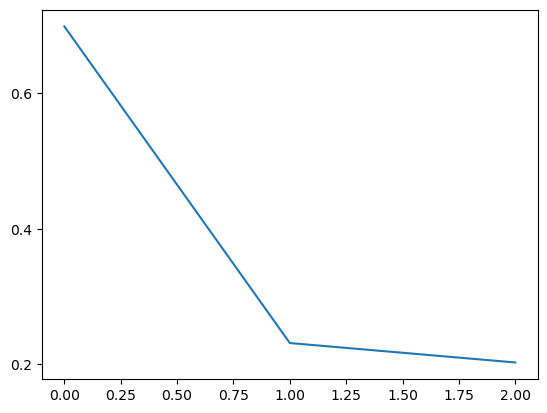

In [274]:
train(trainData, encoder, decoder, n_epochs = 30)

Already after 20 epochs the loss (on training data) was greatly reduced.

### Save the model

This is optional but useful if you train a complex model for long time

In [275]:
PATH = "../outputs/translationModels/"
torch.save(encoder.state_dict(), PATH+"encIT")
torch.save(decoder.state_dict(), PATH+"decIT")

## Translate a sentence  
In inference mode, i.e. when we want to decode unknown input sequences, we go through a slightly different process: there are no targets. Every time it predicts a word we add it to the output string and if it predicts the EOS token we stop there. 

In [276]:
def translate(encoder, decoder, sentence, input_lang, output_lang):
    
    with torch.no_grad():
        
            # transform input sequence into tensors
        input_tensor = tensorFromSentence(input_lang, sentence)
        
            # encode the input sequence into state vectors
        encoder_outputs, encoder_hidden = encoder(input_tensor)
            # Feed the state vectors to the decoder to produce predictions
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

            # Repeat until we generate the end-of-sequence character or we hit the character limit
        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
                # Append the sampled character to the output sequence
            decoded_words.append(output_lang.index2word[idx.item()])
            
    return decoded_words

Let's try with a test sentence:

In [277]:
print(testSentenceEN)

i love machine learning and artificial intelligence


In [278]:
  # let's try first with the test sentence
translationIT = translate(encoder, decoder, testSentenceEN, input_lang, output_lang)
print(' '.join(w for w in translationIT))

io amo il mio popcorn <EOS>


This means "I love my popcorn" which is hilarious. Clearly it's not perfect :)  
Let's evaluate more.

## Evaluation
Evaluation is performed on the original dataset and we can decide if randomly sampling from the training data splice or the part not used for training.  
  
  It's not easy to evaluate a translation because you need to compare two similar strings and langauages are messy and ambiguous, there is not a single way to translate a sentence but multiple ways can be acceptable.  
  
  ### BLEU metric
  **BLEU** (Bilingual Evaluation Understudy) is a metric that evaluates the quality of machine-generated text (like a translation or summary) by comparing its word overlaps (n-grams) to one or more human-created reference texts.
  
The official BLEU calculation is complex due to various heuristics (e.g., handling multiple references, effective reference length, smoothing for zero n-gram counts, tokenization standards) so it's better not to implement BLEU from scratch but instead, to use well-established libraries that have robust and correct implementations.  
We will use the NTLK implementation. Simple and robust.  

#### Smoothing function

In the context of the BLEU score, a smoothing function is a technique used to address the problem of zero n-gram precisions.  
  
What is the problem?  
If even one of the higher-order n-gram precisions (e.g., for bigrams, trigrams, or 4-grams) turns out to be zero, the entire BLEU score becomes zero. This happens because the BLEU score is calculated using a geometric mean of the individual n-gram precisions. If any term in a geometric mean is zero, the product is zero.  
  
This is particularly problematic for:  

- Short sentences: Shorter sentences have fewer possible n-grams, making it more likely that some n-gram orders will have zero matches.

- Poor translations: If a machine translation is very different from the reference, it might have no matching n-grams for certain orders.

- Single-sentence evaluation: BLEU was originally designed for corpus-level evaluation, where aggregating counts over many sentences makes zero counts less likely. When applied to single sentences (as with sentence_bleu), the sparsity problem is much more pronounced.
  
A BLEU score of 0.0, especially for short sentences or slightly off translations, can be overly harsh and not very informative. It doesn't differentiate between a translation that has some overlap but no perfect higher-order matches, and a translation that has no overlap whatsoever.  
  
What does a Smoothing Function do?  
A smoothing function modifies the calculation of n-gram precisions to prevent them from becoming exactly zero. Instead of a zero precision, it substitutes a very small positive value, or it adds a small constant to both the numerator (matched n-gram count) and denominator (total n-gram count) to ensure the precision is never zero. This allows the geometric mean to be calculated and provides a more nuanced score even when perfect matches for all n-gram orders are not found.  

Evaluation doesn't prove a model works: it just discovers the ways it fails, so let's see the mistakes.


In [295]:
  # let's try first with the test sentence
translationIT = translate(encoder, decoder, "this is a very easy sentence", input_lang, output_lang)
print(' '.join(w for w in translationIT))

questo e molto <EOS>


In [296]:
translationIT

['questo', 'e', 'molto', '<EOS>']

In [301]:
actualIT = "questa é una frase molto semplice"


In [241]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


In [279]:
# Initialize the SmoothingFunction object
chencherry = SmoothingFunction()


In [304]:
# Apply a smoothing method (e.g., method1 from Chen & Cherry)
# NLTK offers several methods (method0 to method7).
# method1 is a common simple one.
score_smoothed = sentence_bleu(_splitSentence("ita",actualIT), translationIT[:-1], smoothing_function=chencherry.method1)
print(f"NLTK BLEU-4 (smoothed with method1): {score_smoothed:.2f}")



NLTK BLEU-4 (smoothed with method1): 0.11


As mentioned above, BLEU has limitation when applied to short sentences.  
In this case, a metric of 0.11 is basically a full matching.

In [320]:
def evaluateRandomly(encoder, decoder, pairs, language, onTrain = True, n=3):
    # Sample n sentences from given pairs and translate them using the given dataset (train or test) 
    # and print the result (no return)
    #
    # Inputs:
    # encoder, decoder: the model
    # pairs: the dataset
    # onTrain: boolean; True if sampling to be done on train dataset
    # n: integer; number of sentences to sample; default is 3
    
    chencherry = SmoothingFunction()

    dataset = "train" if onTrain else "test"
    print(f"Evaluating {n} random sentences from {dataset} dataset\n\n")
    
    trainSplit = int(len(pairs) * TRAIN_PERCENT)
    print(f"train split: {trainSplit}")
    
    print("> input sentence in English \n = target sentence translated in selected language \n< Output sentence from the model\n")
    
    for i in range(n):
        pair = random.choice(pairs[:trainSplit]) if onTrain else random.choice(pairs[trainSplit:])
        print('>', pair[0])
        print('=', pair[1])
        #print(_splitSentence(language,pair[1]))
        
        output_words = translate(encoder, decoder, pair[0], input_lang, output_lang)
        
        output_sentence = ' '.join(output_words[:-1])
        print('<', output_sentence)
        #print(output_words)
        
        score_smoothed = sentence_bleu(_splitSentence(language,pair[1]), output_words[:-1], smoothing_function=chencherry.method1)
        print(f"NLTK BLEU-4 (smoothed with method1): {score_smoothed:.2f}")

        print('')


First we try with 3 random sentences from the training dataset:  
- first line is the English sentence
- second line is the target Italian sentence from the Train dataset
- third line is the translated  Italian sentence (which should be the same or similar as the second line) 

In [323]:
evaluateRandomly(encoder, decoder, pairs, "ita")

Evaluating 3 random sentences from train dataset


train split: 36992
> input sentence in English 
 = target sentence translated in selected language 
< Output sentence from the model

> tom's cheating
= tom sta imbrogliando
< tom sta imbrogliando
NLTK BLEU-4 (smoothed with method1): 0.00

> is that new
= e nuovo
< quello e nuovo
NLTK BLEU-4 (smoothed with method1): 0.11

> that's my book
= e il mio libro
< il mio libro
NLTK BLEU-4 (smoothed with method1): 0.00



As expected, **the model is quite good on the training examples** it has seen.  
And this even with limited training.  
  
  Now we try the same with sentences that the model has not seen before.

In [324]:
evaluateRandomly(encoder, decoder, pairs, "ita", onTrain = False)

Evaluating 3 random sentences from test dataset


train split: 36992
> input sentence in English 
 = target sentence translated in selected language 
< Output sentence from the model

> you are on the wrong train
= e sul treno sbagliato
< e in ordine
NLTK BLEU-4 (smoothed with method1): 0.11

> what time did you get to bed last night
= a che ora e andata a letto ieri sera
< a qualcuno e due cuoco
NLTK BLEU-4 (smoothed with method1): 0.06

> the monkey ate my banana
= la scimmia ha mangiato la mia banana
< il mio nome
NLTK BLEU-4 (smoothed with method1): 0.00



And here the results are almost ok; the last sentence is good, only the first one is wrong.  
  
# Other languages
To have a quick try at other languages, we first prepare a helper function to run the pipeline (read, prepare the data, train the model, evaluate):

In [ ]:
def runETLpipeline(language):
        # Step1 : read and prepare the data
    input_lang, output_lang, pairs = prepareData(language, False)   # eng -> chinese
        # Step2: load data
    trainData = get_trainDataloader(input_lang, output_lang, pairs, myDevice)
    
    print("=====")
        # Step3: instantiate the decoder in the output language
    decoder = AttnDecoderRNN(HIDDEN_SIZE, output_lang.n_words)
    decoder = decoder.to(myDevice)
    
    print("Decoder's state_dict:")
    for param_tensor in decoder.state_dict():
        print(param_tensor, "\t", decoder.state_dict()[param_tensor].size())
        
    print("=====")
    print(decoder)
    print("=====")
    
    
        # Step4: training
    train(trainData, encoder, decoder, n_epochs=20, print_every=5, plot_every=5)

    print("=====")
    print (pairs[42]) # verify


        # Step5: evaluation
    evaluateRandomly(encoder, decoder, pairs)
    evaluateRandomly(encoder, decoder, pairs, onTrain = False)
    

# Japanese

Let's see how it works with a non-latin language: Japanese

In [112]:
TRAIN_PERCENT = 0.8  # not many sentences in the dataset so we can increase the train percentage

In [ ]:
#runETLpipeline('jpn')
# I prefer to run each single part, to check mistakes

Train loss was quickly reduced (probably 10-15 epochs would have been enough) and again the train sentences are right translated while the test sentences are wrong.

In [325]:
input_lang, output_lang, pairs = prepareData('jpn', False)   # eng -> chinese


Reading lines...
Read 115492 sentence pairs
Trimmed to 39815 sentence pairs
Counting words...
Counted words:
eng 7167
jpn 10656


In [326]:
input_lang.name

'eng'

In [327]:
output_lang.name

'jpn'

In [328]:
output_lang.n_words

10656

In [329]:
pairs[42]

['hello', 'もしもし']

In [330]:
output_lang.word2index["もしもし"]  # get the index 

6

In [331]:
output_lang.index2word[6]  #  get the word associated to index 2

'もしもし'

In [332]:
input_lang.word2index["hello"] # works also for english 

15

In [333]:
output_lang.word2count['もしもし'] # number of occurences of word 'ciao'

3

In [334]:
pairs[299]

['why not', 'なせいけないの？']

Pairs are the data, basically a list with sentences in pairs: english and foreign language, in this case Italian:

In [335]:
pairs[620]

['i like it', '気に入ってます']

In [336]:
indexesFromSentence(output_lang, pairs[620][1])  # input language is English

[469, 87, 186, 11, 112]

In [337]:
trainData = get_trainDataloader(input_lang, output_lang, pairs, myDevice)


train sentences: 3981


In [338]:
# Check a batch
for src_batch, tgt_batch in trainData:
    print("Source:", src_batch.shape)
    print("Target:", tgt_batch.shape)
    break

Source: torch.Size([32, 10])
Target: torch.Size([32, 10])


In [339]:
# pick a random index less than the batch size.
index = random.randrange(len(src_batch))
index

2

In [340]:
for i in src_batch[index]:
    print (input_lang.index2word[i.item()])

i
left
tom
EOS
SOS
SOS
SOS
SOS
SOS
SOS


In [341]:
for i in tgt_batch[index]:
    print (output_lang.index2word[i.item()])

トム
と
は
別れ
た
わ
よ
EOS
SOS
SOS


In [342]:
decoder = AttnDecoderRNN(HIDDEN_SIZE, output_lang.n_words)
decoder = decoder.to(myDevice)


In [343]:
print("Decoder's state_dict:")
for param_tensor in decoder.state_dict():
    print(param_tensor, "\t", decoder.state_dict()[param_tensor].size())


Decoder's state_dict:
embedding.weight 	 torch.Size([10656, 128])
attention.Wa.weight 	 torch.Size([128, 128])
attention.Wa.bias 	 torch.Size([128])
attention.Ua.weight 	 torch.Size([128, 128])
attention.Ua.bias 	 torch.Size([128])
attention.Va.weight 	 torch.Size([1, 128])
attention.Va.bias 	 torch.Size([1])
gru.weight_ih_l0 	 torch.Size([384, 256])
gru.weight_hh_l0 	 torch.Size([384, 128])
gru.bias_ih_l0 	 torch.Size([384])
gru.bias_hh_l0 	 torch.Size([384])
out.weight 	 torch.Size([10656, 128])
out.bias 	 torch.Size([10656])


Starting train of the model ...
time since start (estimated remaining) | epoch / 30 | progress (%) | loss average
1m 39s (- 3m 19s) | 10 | 33% | 1.7735
3m 25s (- 1m 42s) | 20 | 66% | 0.7065
4m 56s (- 0m 0s) | 30 | 100% | 0.3200
Training completed. Here is the loss plot:


<Figure size 640x480 with 0 Axes>

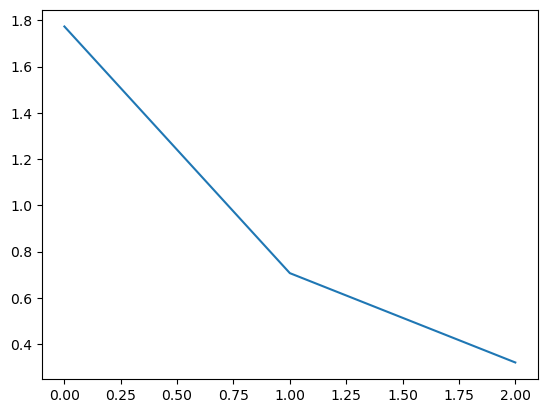

In [344]:
train(trainData, encoder, decoder, n_epochs=30)

In [345]:
translationCM = translate(encoder, decoder, 'there is no limit to the universe', input_lang, output_lang)
print(' '.join(w for w in translationCM))

彼女 は 背 か 高い <EOS>


Almost ...  there is no room in.

In [348]:
evaluateRandomly(encoder, decoder, pairs, "jpn")

Evaluating 3 random sentences from train dataset


train split: 3981
> input sentence in English 
 = target sentence translated in selected language 
< Output sentence from the model

> years passed
= 年月か経った
< 年月 か 経っ まし た
NLTK BLEU-4 (smoothed with method1): 0.06

> no one died
= 誰も死ななかった
< 誰 も 死な なかっ なかっ た 虚しい 死ん しゃっ
NLTK BLEU-4 (smoothed with method1): 0.03

> good for you
= 良かったてすね
< 良かったて す か ?
NLTK BLEU-4 (smoothed with method1): 0.07



# Chinese
Let's do the same with Chinese

In [349]:
TRAIN_PERCENT = 0.8 # even bigger train dataset, hopefully this will improve the model

In [350]:
input_lang, output_lang, pairs = prepareData('cmn', False)   # eng -> chinese


Reading lines...
Read 30919 sentence pairs
Trimmed to 11077 sentence pairs
Counting words...
Counted words:
eng 4104
cmn 6930


In [351]:
pairs[42]

['be nice', '友善点']

In [352]:
indexesFromSentence(output_lang, pairs[42][1])  # input language is English

[57, 55]

In [353]:
output_lang.index2word[57]  

'友善'

In [354]:
pairs[599]

['release him', '放开他']

In [355]:
trainData = get_trainDataloader(input_lang, output_lang, pairs, myDevice)


train sentences: 8861


In [356]:
# Check a batch
for src_batch, tgt_batch in trainData:
    print("Source:", src_batch.shape)
    print("Target:", tgt_batch.shape)
    break

Source: torch.Size([32, 10])
Target: torch.Size([32, 10])


In [357]:
# pick a random index less than the batch size.
index = random.randrange(len(src_batch))
index

7

In [358]:
for i in src_batch[index]:
    print (input_lang.index2word[i.item()])

it
is
pitch
dark
EOS
SOS
SOS
SOS
SOS
SOS


In [359]:
for i in tgt_batch[index]:
    print (output_lang.index2word[i.item()])

天色
漆黑
EOS
SOS
SOS
SOS
SOS
SOS
SOS
SOS


In [360]:
decoder = AttnDecoderRNN(HIDDEN_SIZE, output_lang.n_words)
decoder = decoder.to(myDevice)


In [361]:
print("Decoder's state_dict:")
for param_tensor in decoder.state_dict():
    print(param_tensor, "\t", decoder.state_dict()[param_tensor].size())


Decoder's state_dict:
embedding.weight 	 torch.Size([6930, 128])
attention.Wa.weight 	 torch.Size([128, 128])
attention.Wa.bias 	 torch.Size([128])
attention.Ua.weight 	 torch.Size([128, 128])
attention.Ua.bias 	 torch.Size([128])
attention.Va.weight 	 torch.Size([1, 128])
attention.Va.bias 	 torch.Size([1])
gru.weight_ih_l0 	 torch.Size([384, 256])
gru.weight_hh_l0 	 torch.Size([384, 128])
gru.bias_ih_l0 	 torch.Size([384])
gru.bias_hh_l0 	 torch.Size([384])
out.weight 	 torch.Size([6930, 128])
out.bias 	 torch.Size([6930])


Starting train of the model ...
time since start (estimated remaining) | epoch / 80 | progress (%) | loss average
4m 49s (- 14m 27s) | 20 | 25% | 1.0840
9m 54s (- 9m 54s) | 40 | 50% | 0.1633
14m 31s (- 4m 50s) | 60 | 75% | 0.0631
19m 8s (- 0m 0s) | 80 | 100% | 0.0441
Training completed. Here is the loss plot:


<Figure size 640x480 with 0 Axes>

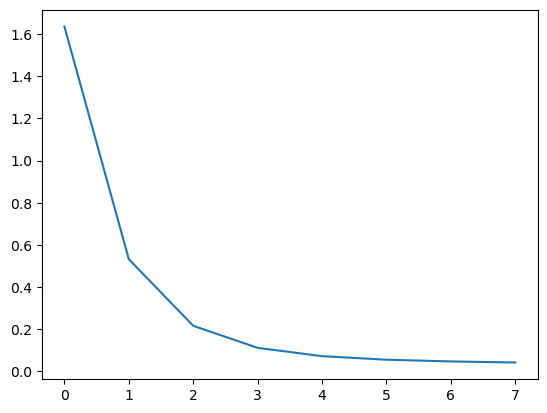

In [362]:
train(trainData, encoder, decoder, n_epochs=80, print_every=20)

In [363]:
  # let's try first with the test sentence
output_lang.name


'cmn'

In [364]:
translationCM = translate(encoder, decoder, 'i love artificial intelligence', input_lang, output_lang)
print(' '.join(w for w in translationCM))

我 爱 輕 <EOS>


" I love this machine"  
almost...

In [366]:
evaluateRandomly(encoder, decoder, pairs, "cmn")

Evaluating 3 random sentences from train dataset


train split: 8861
> input sentence in English 
 = target sentence translated in selected language 
< Output sentence from the model

> don't touch my camera
= 不要碰我的相機
< 不要 碰 我 的 相機
NLTK BLEU-4 (smoothed with method1): 0.07

> can i touch it
= 可以碰嗎？
< 可以 碰 嗎 ？
NLTK BLEU-4 (smoothed with method1): 0.11

> i work in a factory
= 我在一家工廠工作
< 我 在 一家 工廠 工作
NLTK BLEU-4 (smoothed with method1): 0.06



In [367]:
evaluateRandomly(encoder, decoder, pairs, "cmn", onTrain = False)

Evaluating 3 random sentences from test dataset


train split: 8861
> input sentence in English 
 = target sentence translated in selected language 
< Output sentence from the model

> tom visited boston last year
= 湯姆去年去了波士頓
< 汤姆 住 波士顿
NLTK BLEU-4 (smoothed with method1): 0.00

> the election was unanimous
= 选举一致通过了
< 选举 一致 号 有没有 空 了 ？
NLTK BLEU-4 (smoothed with method1): 0.03

> my passport's been stolen
= 我的护照被人偷了
< 我 的 表 被 提到 赢 了
NLTK BLEU-4 (smoothed with method1): 0.05



# German to English

Finally, let's see how it works with a reversed translation: from German to English

In [368]:
input_lang, output_lang, pairs = prepareData('deu', True)   # German -> english


Reading lines...
Read 320340 sentence pairs
Trimmed to 275316 sentence pairs
Counting words...
Counted words:
deu 38787
eng 19300


The input and output languages contain several attributes (name, number of words, ...) and methods (convert a word into its index and viceversa):

In [369]:
input_lang.name

'deu'

In [370]:
output_lang.name

'eng'

In [371]:
output_lang.n_words

19300

In [372]:
output_lang.word2index["hello"]  # get the index of english word "hello"

17

In [373]:
output_lang.index2word[17]

'hello'

In [374]:
input_lang.word2index["liebe"] # german

626

In [375]:
output_lang.word2count['hello'] # number of occurences of word 'hello'

56

Pairs are the data, basically a list with sentences in pairs: english and foreign language, in this case German:

In [376]:
pairs[42]

['entschuldigung', 'sorry']

In [377]:
TRAIN_PERCENT = 0.1  # huge train dataset

In [378]:
trainData = get_trainDataloader(input_lang, output_lang, pairs, myDevice)


train sentences: 27531


In [379]:
# Check a batch
for src_batch, tgt_batch in trainData:
    print("Source:", src_batch.shape)
    print("Target:", tgt_batch.shape)
    break

Source: torch.Size([32, 10])
Target: torch.Size([32, 10])


In [380]:
# pick a random index less than the batch size.
index = random.randrange(len(src_batch))
index

2

In [381]:
print(tgt_batch[index])

tensor([  59, 1748,    1,    0,    0,    0,    0,    0,    0,    0])


In [382]:
for i in tgt_batch[index]:
    print (output_lang.index2word[i.item()])

i'm
expecting
EOS
SOS
SOS
SOS
SOS
SOS
SOS
SOS


In [383]:
print(src_batch[index])

tensor([  33,   88,  776, 2477,    1,    0,    0,    0,    0,    0])


In [384]:
for i in src_batch[index]:
    print (input_lang.index2word[i.item()])

ich
bin
guter
hoffnung
EOS
SOS
SOS
SOS
SOS
SOS


In [385]:
decoder = AttnDecoderRNN(HIDDEN_SIZE, output_lang.n_words)
decoder = decoder.to(myDevice)


In [386]:
print("Decoder's state_dict:")
for param_tensor in decoder.state_dict():
    print(param_tensor, "\t", decoder.state_dict()[param_tensor].size())


Decoder's state_dict:
embedding.weight 	 torch.Size([19300, 128])
attention.Wa.weight 	 torch.Size([128, 128])
attention.Wa.bias 	 torch.Size([128])
attention.Ua.weight 	 torch.Size([128, 128])
attention.Ua.bias 	 torch.Size([128])
attention.Va.weight 	 torch.Size([1, 128])
attention.Va.bias 	 torch.Size([1])
gru.weight_ih_l0 	 torch.Size([384, 256])
gru.weight_hh_l0 	 torch.Size([384, 128])
gru.bias_ih_l0 	 torch.Size([384])
gru.bias_hh_l0 	 torch.Size([384])
out.weight 	 torch.Size([19300, 128])
out.bias 	 torch.Size([19300])


In [387]:
decoder

AttnDecoderRNN(
  (embedding): Embedding(19300, 128)
  (attention): BahdanauAttention(
    (Wa): Linear(in_features=128, out_features=128, bias=True)
    (Ua): Linear(in_features=128, out_features=128, bias=True)
    (Va): Linear(in_features=128, out_features=1, bias=True)
  )
  (gru): GRU(256, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=19300, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

Starting train of the model ...
time since start (estimated remaining) | epoch / 30 | progress (%) | loss average
12m 35s (- 25m 10s) | 10 | 33% | 0.7688
25m 33s (- 12m 46s) | 20 | 66% | 0.1994
39m 11s (- 0m 0s) | 30 | 100% | 0.1050
Training completed. Here is the loss plot:


<Figure size 640x480 with 0 Axes>

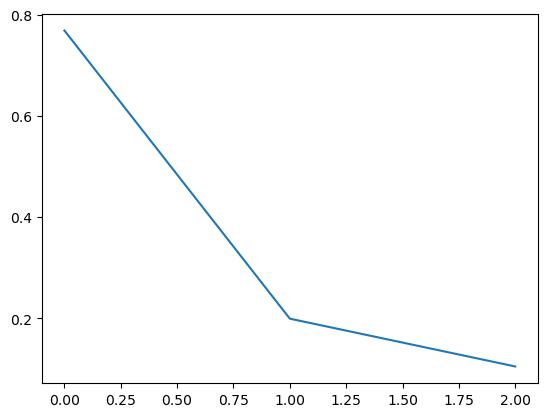

In [388]:
train(trainData, encoder, decoder, n_epochs = 30)

In [389]:
translationEN = translate(encoder, decoder, 'ich liebe dich', input_lang, output_lang)
print(' '.join(w for w in translationEN))

i love you <EOS>


In [397]:
        # get the training split
n = len(pairs)
trainSplit = int(n * TRAIN_PERCENT)
print(f"train sentences: {trainSplit}")

train sentences: 27531


In [394]:
evaluateRandomly(encoder, decoder, pairs, "deu")

Evaluating 3 random sentences from train dataset


train split: 27531
> input sentence in English 
 = target sentence translated in selected language 
< Output sentence from the model

> das hat niemand gesagt
= no one said that
< nobody said that
NLTK BLEU-4 (smoothed with method1): 0.00

> es ist so still
= it's so quiet
< it's so quiet
NLTK BLEU-4 (smoothed with method1): 0.00

> komm, sing mit mir
= come sing with me
< i sing
NLTK BLEU-4 (smoothed with method1): 0.15



Almost perfect, with few epochs and few examples, even if the BLEU metric is not correct (too short sentences)

In [398]:
evaluateRandomly(encoder, decoder, pairs, "deu", onTrain = False)

Evaluating 3 random sentences from test dataset


train split: 27531
> input sentence in English 
 = target sentence translated in selected language 
< Output sentence from the model

> tom ist nie nach hause gekommen
= tom never came home
< tom made home
NLTK BLEU-4 (smoothed with method1): 0.00

> ich habe gehort, daß ihr jemanden dafur bezahlt hattet
= i heard that you paid someone to do that
< i saw you
NLTK BLEU-4 (smoothed with method1): 0.11

> vielleicht konnten sie mir helfen
= maybe you could help me
< i may tell me
NLTK BLEU-4 (smoothed with method1): 0.00



In [410]:
def evaluateOnTest(encoder, decoder, pairs, input_lang, output_lang):

    bleuTotal = 0
    n = 0
    
    for i in range(trainSplit+1, len(pairs)):
        try:
            output_words = translate(encoder, decoder, pairs[i][0], input_lang, output_lang)

            
            output_sentence = ' '.join(output_words)
            output_sentence = output_sentence.removesuffix("<EOS>")

            b = sentence_bleu(output_sentence, pairs[i][1], smoothing_function=chencherry.method1)
            bleuTotal += b
            n += 1

        except:
            continue   # just skip if there was any problem (usually word not found)
            
    print("Total examples analysed =", n)
    print(f"Average BLEU (smoothed): {(bleuTotal/n):.3f}")

In [411]:
evaluateOnTest(encoder, decoder, pairs, input_lang, output_lang)


Total examples analysed = 201183
Average BLEU (smoothed): 0.012
